# Neural Quantum Dynamics Emulator (Part III)

### Scope of this notebook

1. We include the full model test results.
2. We show the hyper-parameter tuning results.
3. We show how to calculate and visulize the input-feature importance.

In [78]:
# Computation libraries
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.animation as animation

from matplotlib.animation import FuncAnimation
from optimization import create_optimizer
from IPython.display import HTML
from utils import *
from models import *

import seaborn as sns
sns.set_style("whitegrid")
# sns.set()

## Section 7: Full Models Results


We can plot the loss and correlation of all 25 hand made test cases simulated by the full model.

<Figure size 1296x864 with 0 Axes>

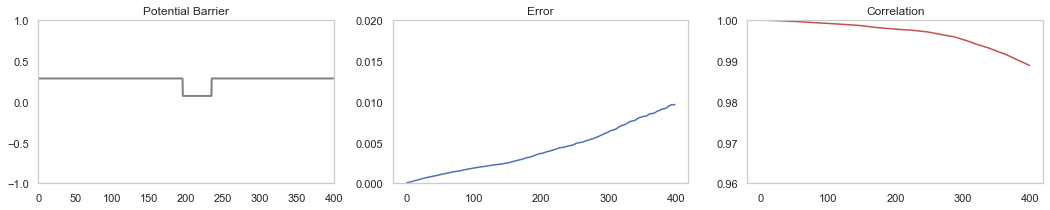

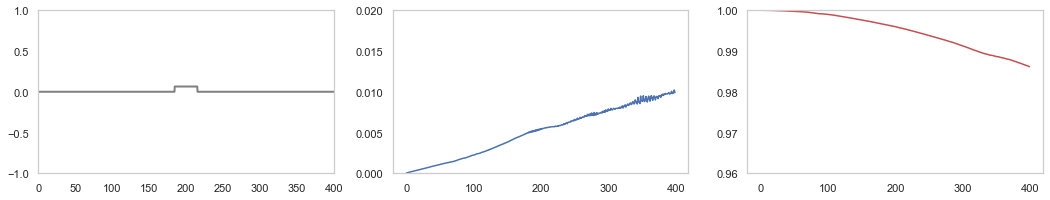

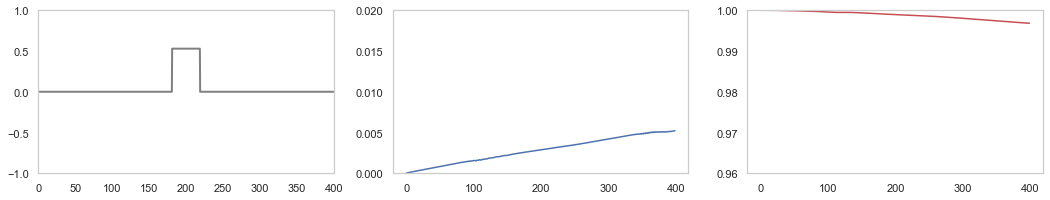

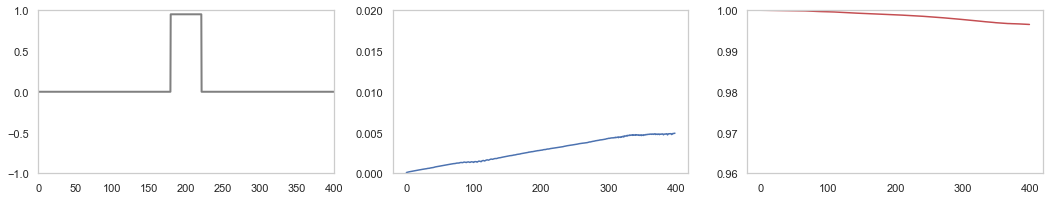

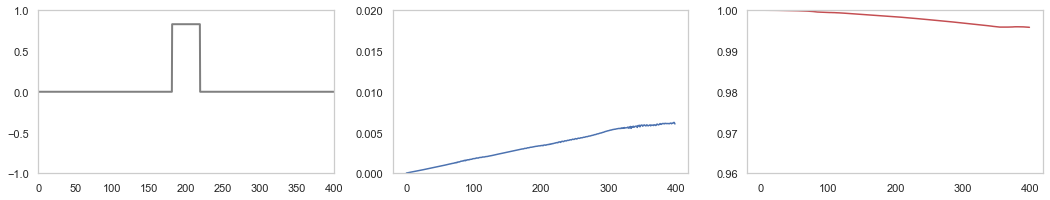

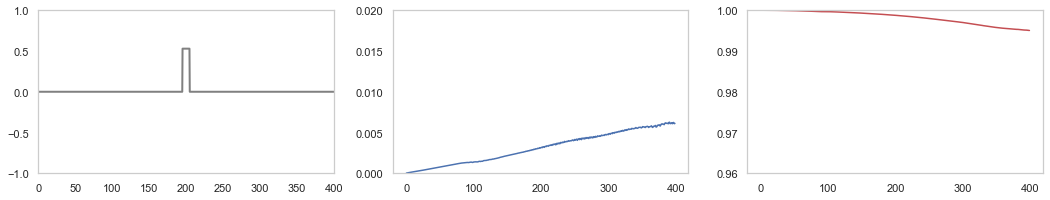

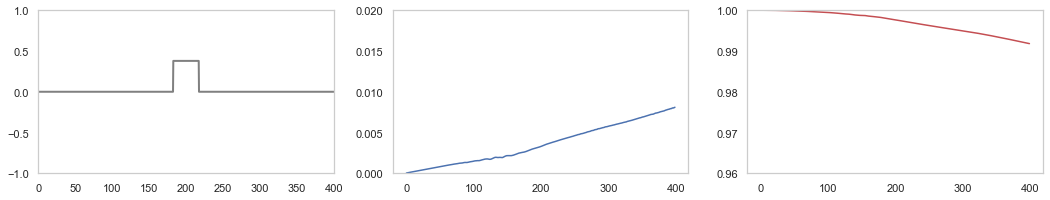

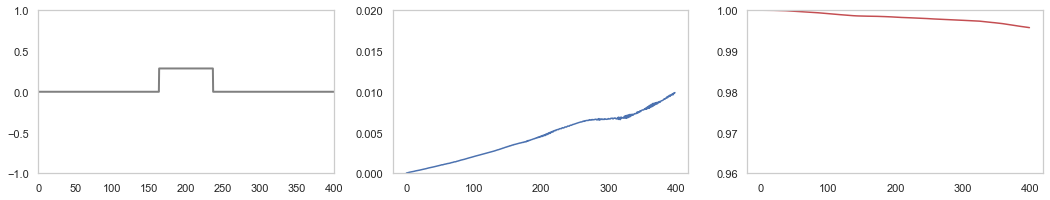

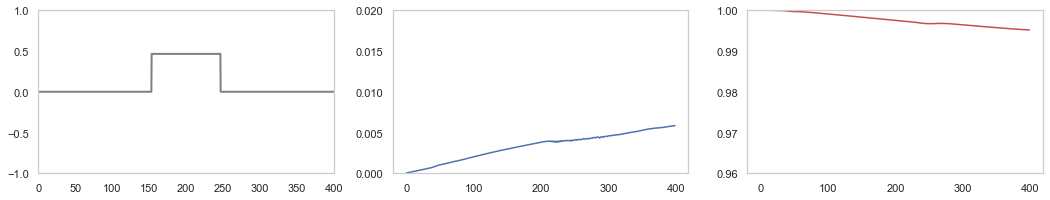

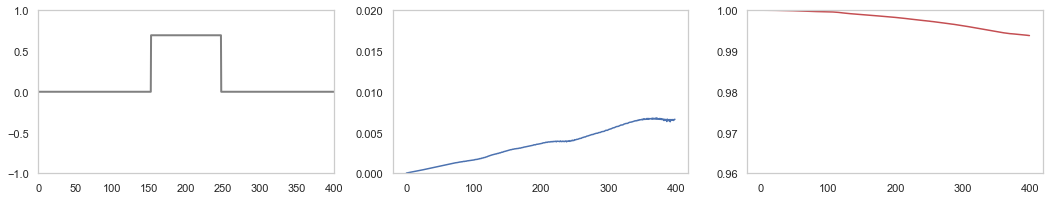

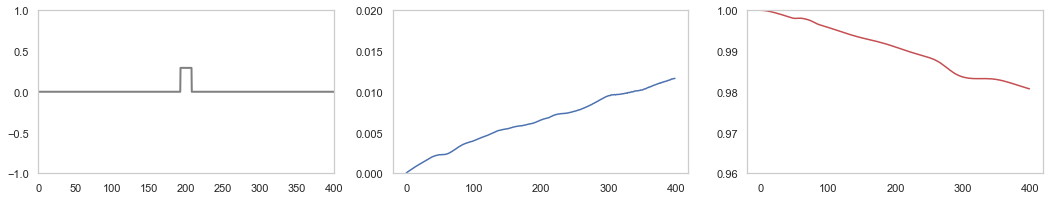

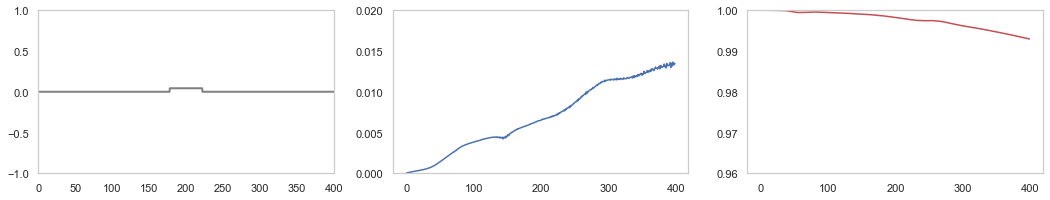

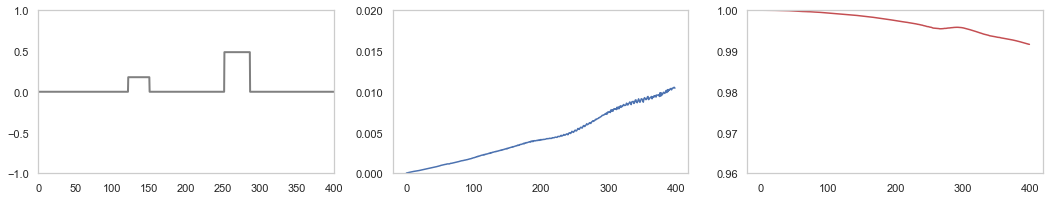

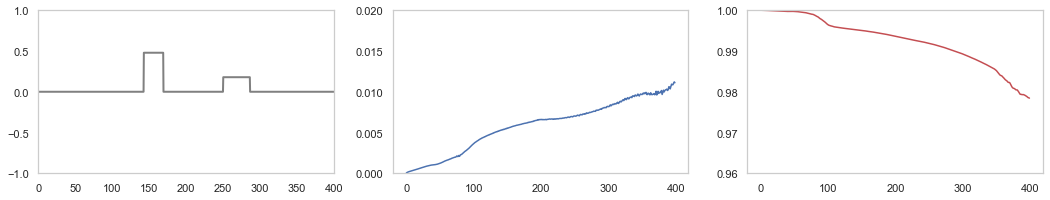

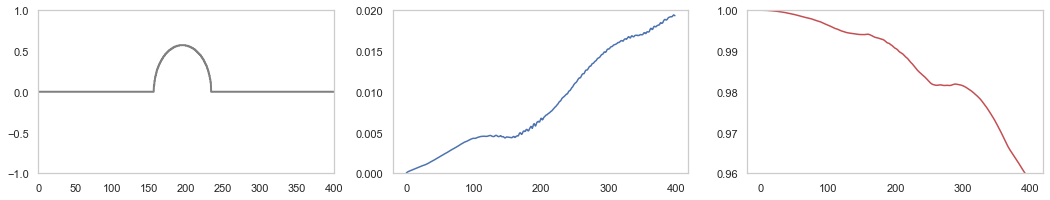

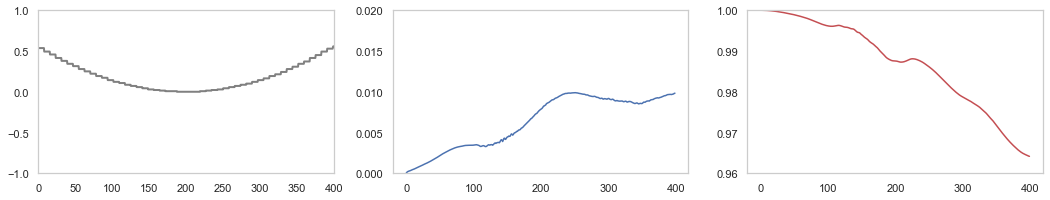

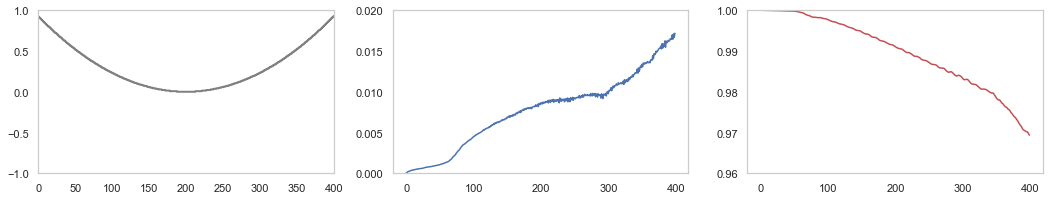

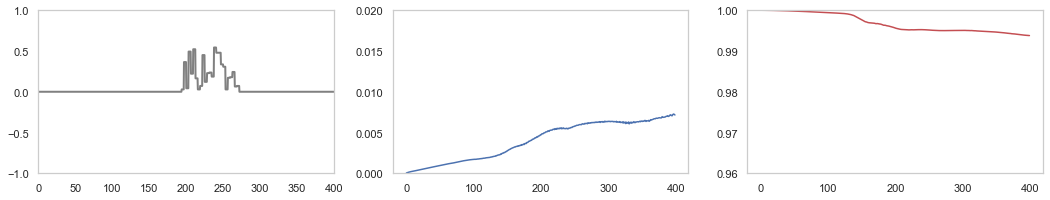

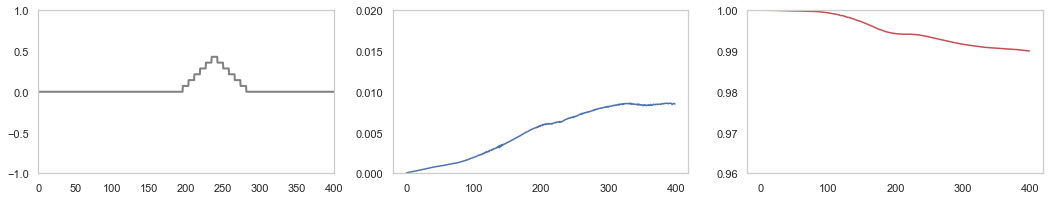

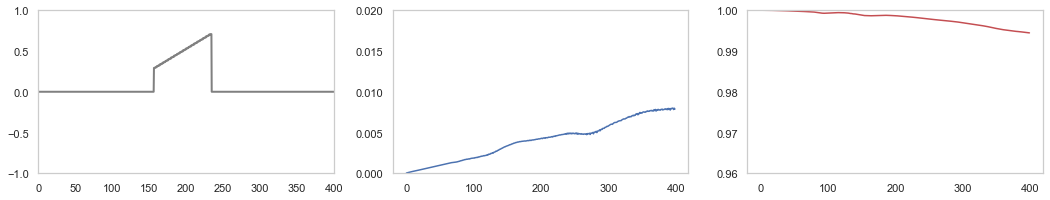

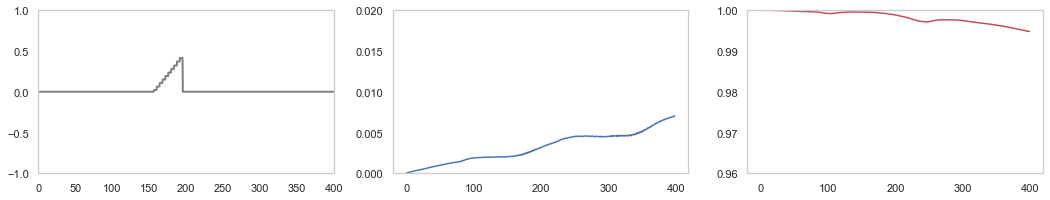

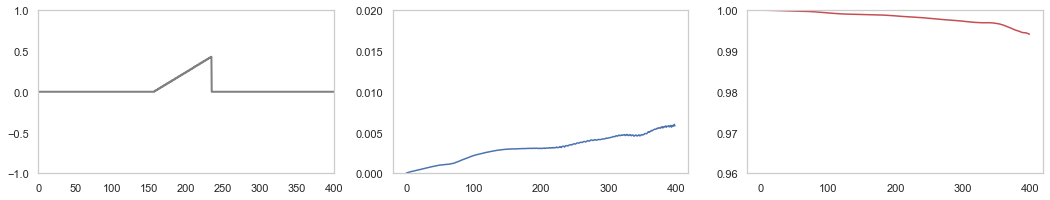

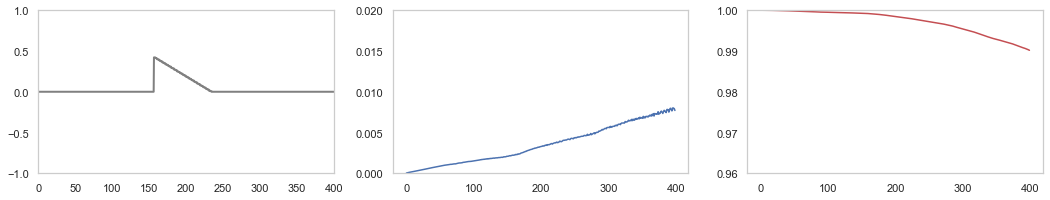

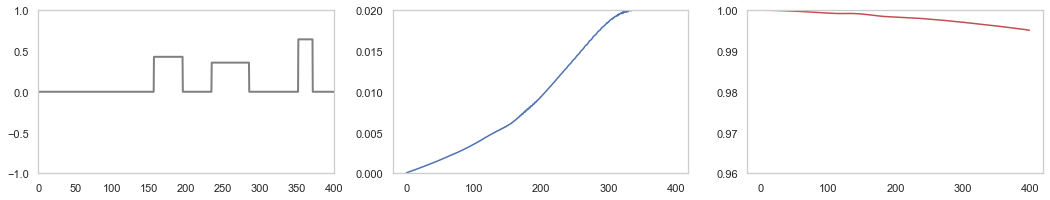

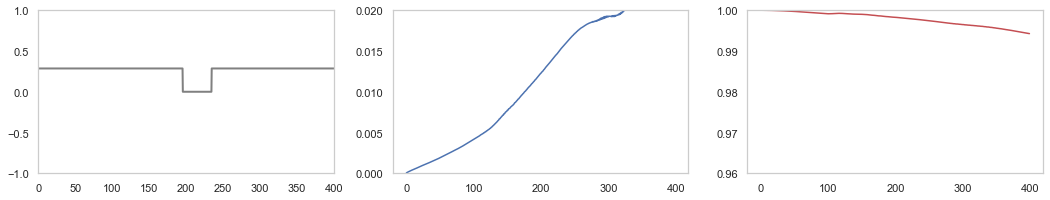

In [92]:
full_npz = np.load("full-gru-results.npz")
fig = plt.figure(figsize=(18,12))
test_files = sorted(tf.io.gfile.glob("../datasets/test/full_test_E0_0.0to9.0_BH_0.0to14.0/*.txt"))
corr = full_npz['all_corr']
loss = full_npz['all_loss']
plt.rcParams.update({'figure.max_open_warning': 0})
for i in range(25):
    data = retrieve_data(test_files[i-1],14.)
    fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(18,3))
    if i == 0:
        ax1.set_title('Potential Barrier')
        ax2.set_title('Error')
        ax3.set_title('Correlation')
        
    #Plot Potential
    ax1.grid(False)
    ax1.set_xlim(0,400)
    ax1.set_ylim(-1,1)
    x = np.linspace(0, 400, int(data["params"][0][0]))
    line = ax1.plot([], [], lw=2, color="gray")[0]
    line.set_data(x,data['pot'][0])
    
    #Plot Error
    ax2.grid(False)
    ax2.plot(loss[0,i,:])
    ax2.set_ylim(0,0.02)
    
    #Plot Correlation
    ax3.grid(False)
    ax3.plot(corr[0,i,:], color='r')
    ax3.set_ylim(0.96,1)

plt.show()

We can build the animation for a specific model with a specific test file to see the actual performance of it.

In [3]:
test_file = "../datasets/test/full_test_E0_0.0to9.0_BH_0.0to14.0/X0_15.1_S0_1.7_E0_6.4_BH_7.4_BW_9.4.txt"
model = RNNModel
config = Config()
full_ckpt = "../models/full-gru/ckpts/final_step"
demo_ckpt = "../models/demo-gru/ckpts/final_step"

HTML(show_animation(config,model,full_ckpt,test_file))

In [4]:
HTML(show_animation(config,model,demo_ckpt,test_file))

In [2]:
test_file = "../datasets/test/full_test_E0_0.0to9.0_BH_0.0to14.0/X0_15.1_S0_1.7_E0_6.4_BH_7.4_BW_9.4.txt"
pot_scalar_full = 14.0
pot_scalar_demo = 10.0


# demo_ckpt = "../models/demo-gru/ckpts/final_step"
config = Config(input_channels=3, hidden_size=69)
full_model = RNNModel(config)
demo_model = RNNModel(config)

full_data = retrieve_data(test_file, pot_scalar_full)
demo_data = retrieve_data(test_file, pot_scalar_demo)
full_model.load_weights(full_ckpt)
demo_model.load_weights(demo_ckpt)

full_result = get_result(full_model, config, full_data)
demo_result = get_result(demo_model, config, demo_data)

full_anim = build_anime(config, full_data, full_result,pot_scalar_full)
demo_anim = build_anime(config, demo_data, demo_result,pot_scalar_demo)

In [3]:
HTML(full_anim.to_html5_video())

In [4]:
HTML(demo_anim.to_html5_video())

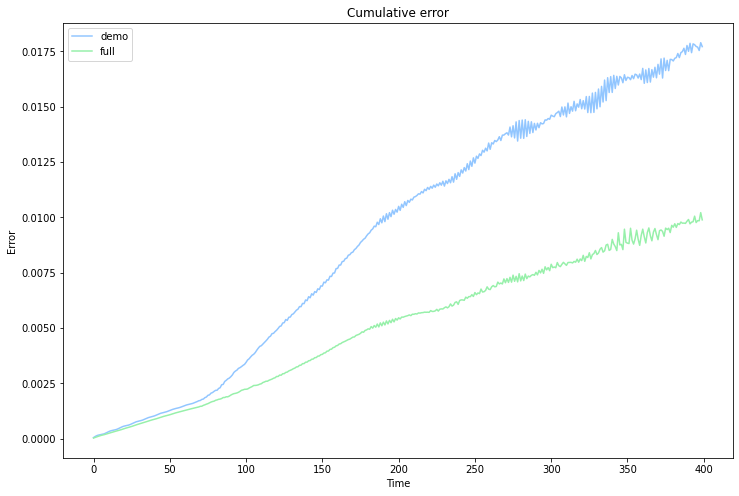

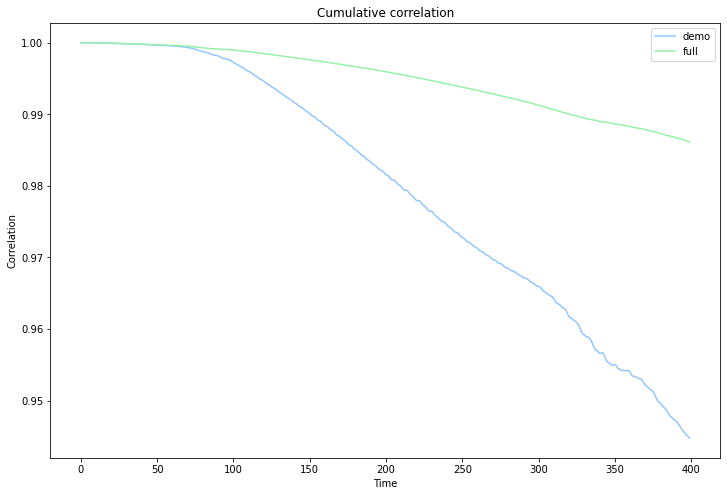

In [5]:
fig = plt.figure(figsize = (12,8))
plt.plot(get_loss(config,demo_data,demo_result), label = 'demo')
plt.plot(get_loss(config,full_data,full_result), label = 'full')
plt.xlabel('Time')
plt.ylabel('Error')
plt.title('Cumulative error')
plt.legend()
plt.savefig("complex-error.png")

fig2 = plt.figure(figsize = (12,8))
plt.plot(get_corr(config,demo_data,demo_result), label = 'demo')
plt.plot(get_corr(config,full_data,full_result), label = 'full')
plt.xlabel('Time')
plt.ylabel('Correlation')
plt.title('Cumulative correlation')
plt.legend()
plt.savefig("complex-corr.png")

In [11]:
class RNNModel_LSTM(tf.keras.Model):
    def __init__(self, config):
        super().__init__()
        self.flatten = layers.Reshape((config.input_frames, config.window_size * config.input_channels))
        self.dense1 = layers.Dense(config.hidden_size, activation="relu")
        self.lstm = tf.keras.layers.LSTM(config.hidden_size, return_state=True, activation='relu', dropout=config.dropout_rate)
        self.dense2 = layers.Dense(config.window_size * config.output_channels)
        self.reshape = layers.Reshape((config.window_size, config.output_channels))

    def call(self, input_tensor, training=False):
        x = self.flatten(input_tensor)
        x = self.dense1(x)
        output, final_state, final_carry = self.lstm(x, initial_state=None, training=training)
        x = tf.concat((output, final_state, final_carry), axis=-1)
        x = self.dense2(x)
        x = self.reshape(x)
        return x

conf_lstm = Config(model_name="demo-lstm")
m_lstm = RNNModel_LSTM(conf_lstm)
m_lstm.build((None, conf_lstm.input_frames, conf_lstm.window_size, conf_lstm.input_channels))
m_lstm.summary()

Model: "rnn_model_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_9 (Reshape)          multiple                  0         
_________________________________________________________________
dense_9 (Dense)              multiple                  4830      
_________________________________________________________________
lstm (LSTM)                  multiple                  38364     
_________________________________________________________________
dense_10 (Dense)             multiple                  9568      
_________________________________________________________________
reshape_10 (Reshape)         multiple                  0         
Total params: 52,762
Trainable params: 52,762
Non-trainable params: 0
_________________________________________________________________


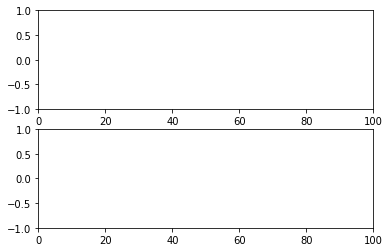

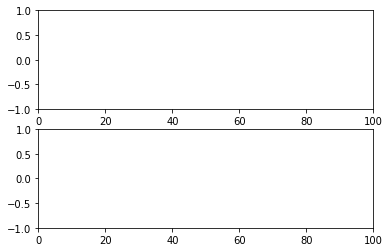

In [12]:
test_file = "../datasets/test/full_test_E0_0.0to9.0_BH_0.0to14.0/X0_15.1_S0_1.7_E0_6.4_BH_7.4_BW_9.4.txt"
pot_scalar_full = 10.0
pot_scalar_demo = 10.0

full_ckpt = "../models/demo-lstm/ckpts/final_step"
demo_ckpt = "../models/demo-gru/ckpts/final_step"

config = Config()

full_model = RNNModel_LSTM(config)
demo_model = RNNModel(config)

full_data = retrieve_data(test_file, pot_scalar_full)
demo_data = retrieve_data(test_file, pot_scalar_demo)

full_model.load_weights(full_ckpt)
demo_model.load_weights(demo_ckpt)

full_result = get_result(full_model, config, full_data)
demo_result = get_result(demo_model, config, demo_data)

full_anim = build_anime(config, full_data, full_result,pot_scalar_full)
demo_anim = build_anime(config, demo_data, demo_result,pot_scalar_demo)

In [13]:
HTML(full_anim.to_html5_video()) #LSTM

In [14]:
HTML(demo_anim.to_html5_video()) #GRU

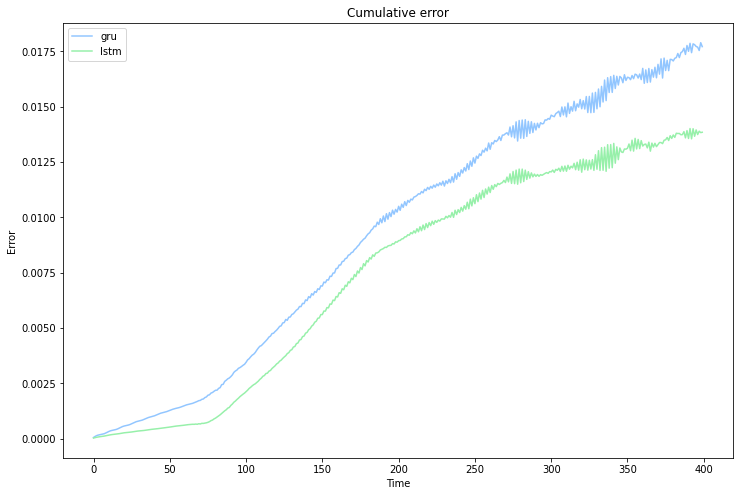

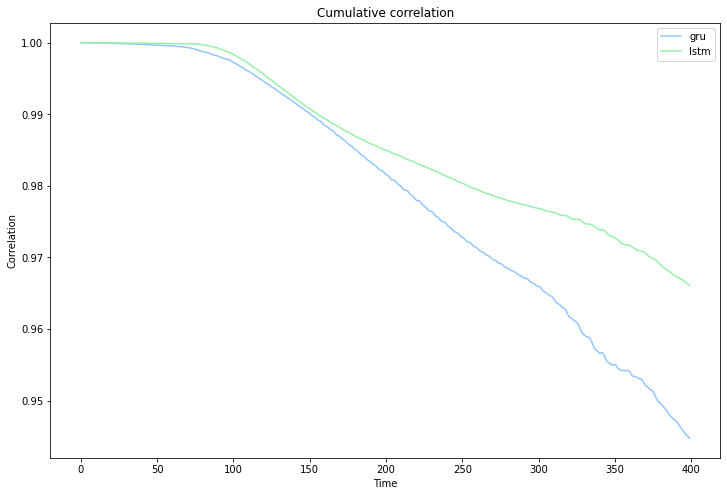

In [16]:
fig = plt.figure(figsize = (12,8))
plt.plot(get_loss(config,demo_data,demo_result), label = 'gru')
plt.plot(get_loss(config,full_data,full_result), label = 'lstm')
plt.xlabel('Time')
plt.ylabel('Error')
plt.title('Cumulative error')
plt.legend()

fig2 = plt.figure(figsize = (12,8))
plt.plot(get_corr(config,demo_data,demo_result), label = 'gru')
plt.plot(get_corr(config,full_data,full_result), label = 'lstm')
plt.xlabel('Time')
plt.ylabel('Correlation')
plt.title('Cumulative correlation')
plt.legend()

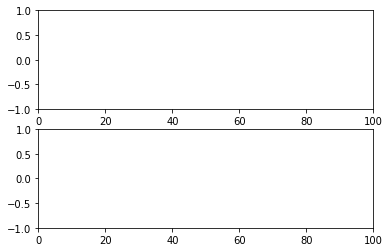

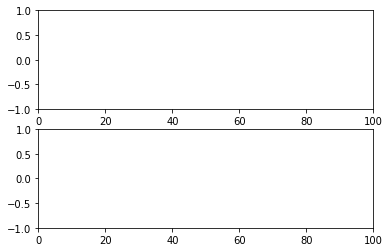

In [17]:
test_file = "../datasets/test/full_test_E0_0.0to9.0_BH_0.0to14.0/triple.txt"
pot_scalar_full = 10.0
pot_scalar_demo = 10.0

full_ckpt = "../models/demo-lstm/ckpts/final_step"
demo_ckpt = "../models/demo-gru/ckpts/final_step"

config = Config()

full_model = RNNModel_LSTM(config)
demo_model = RNNModel(config)

full_data = retrieve_data(test_file, pot_scalar_full)
demo_data = retrieve_data(test_file, pot_scalar_demo)

full_model.load_weights(full_ckpt)
demo_model.load_weights(demo_ckpt)

full_result = get_result(full_model, config, full_data)
demo_result = get_result(demo_model, config, demo_data)

full_anim = build_anime(config, full_data, full_result,pot_scalar_full)
demo_anim = build_anime(config, demo_data, demo_result,pot_scalar_demo)

In [18]:
HTML(full_anim.to_html5_video())

In [19]:
HTML(demo_anim.to_html5_video())

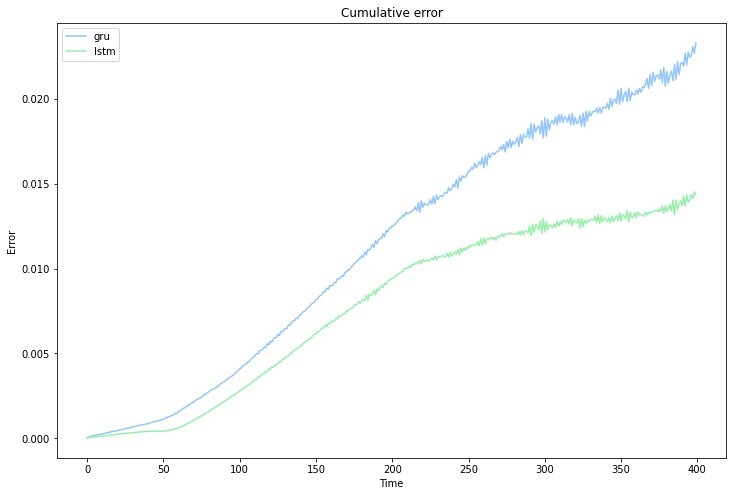

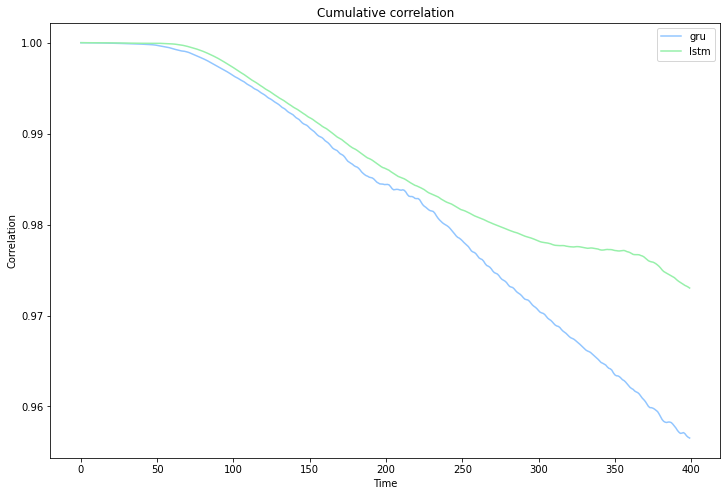

In [20]:
fig = plt.figure(figsize = (12,8))
plt.plot(get_loss(config,demo_data,demo_result), label = 'gru')
plt.plot(get_loss(config,full_data,full_result), label = 'lstm')
plt.xlabel('Time')
plt.ylabel('Error')
plt.title('Cumulative error')
plt.legend()

fig2 = plt.figure(figsize = (12,8))
plt.plot(get_corr(config,demo_data,demo_result), label = 'gru')
plt.plot(get_corr(config,full_data,full_result), label = 'lstm')
plt.xlabel('Time')
plt.ylabel('Correlation')
plt.title('Cumulative correlation')
plt.legend()

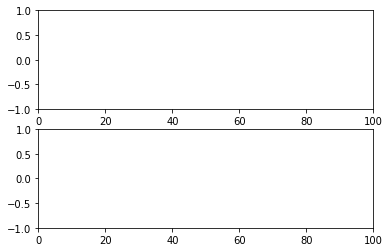

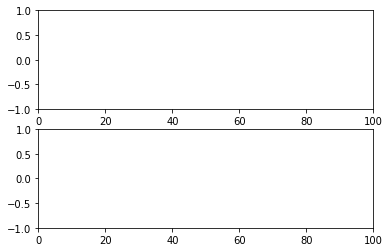

In [21]:
test_file = "../datasets/test/full_test_E0_0.0to9.0_BH_0.0to14.0/random.txt"
pot_scalar_full = 10.0
pot_scalar_demo = 10.0

full_ckpt = "../models/demo-lstm/ckpts/final_step"
demo_ckpt = "../models/demo-gru/ckpts/final_step"

config = Config()

full_model = RNNModel_LSTM(config)
demo_model = RNNModel(config)

full_data = retrieve_data(test_file, pot_scalar_full)
demo_data = retrieve_data(test_file, pot_scalar_demo)

full_model.load_weights(full_ckpt)
demo_model.load_weights(demo_ckpt)

full_result = get_result(full_model, config, full_data)
demo_result = get_result(demo_model, config, demo_data)

full_anim = build_anime(config, full_data, full_result,pot_scalar_full)
demo_anim = build_anime(config, demo_data, demo_result,pot_scalar_demo)

In [22]:
HTML(full_anim.to_html5_video())

In [23]:
HTML(demo_anim.to_html5_video())

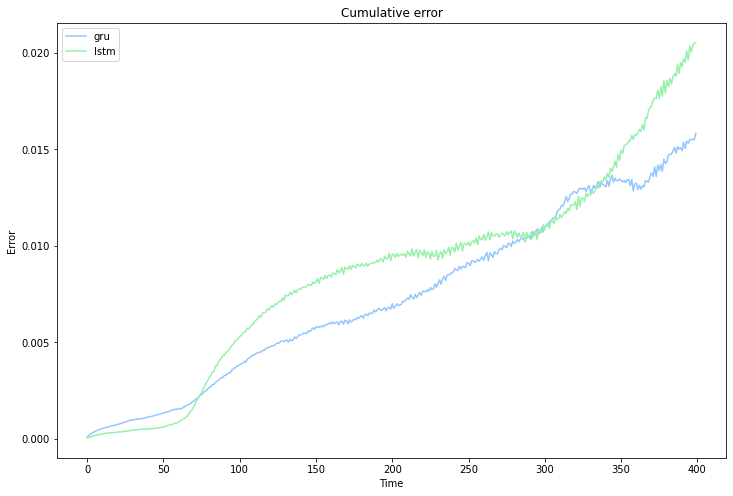

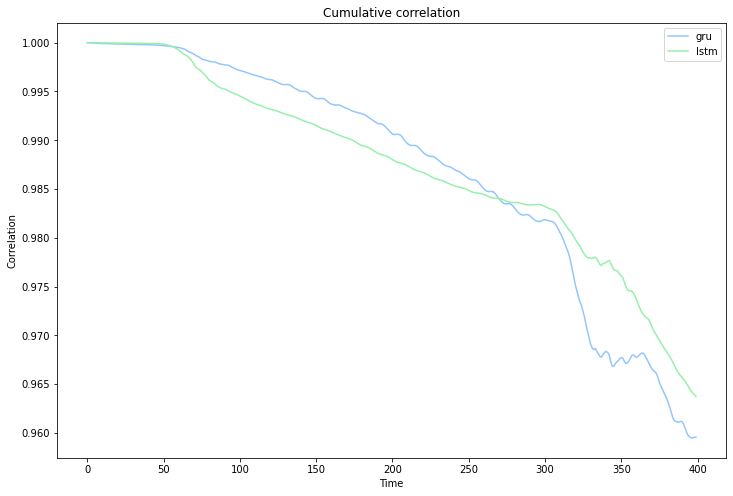

In [24]:
fig = plt.figure(figsize = (12,8))
plt.plot(get_loss(config,demo_data,demo_result), label = 'gru')
plt.plot(get_loss(config,full_data,full_result), label = 'lstm')
plt.xlabel('Time')
plt.ylabel('Error')
plt.title('Cumulative error')
plt.legend()

fig2 = plt.figure(figsize = (12,8))
plt.plot(get_corr(config,demo_data,demo_result), label = 'gru')
plt.plot(get_corr(config,full_data,full_result), label = 'lstm')
plt.xlabel('Time')
plt.ylabel('Correlation')
plt.title('Cumulative correlation')
plt.legend()

In [7]:
target = np.stack([demo_data["psi_re"], demo_data["psi_im"]], axis=-1)

In [18]:
a = target[0 + 0 + config.input_frames]
b = demo_result[0].numpy()

In [22]:
true = data["psi_re"][config.input_frames:config.input_frames+total_frames] + 1j * data["psi_im"][config.input_frames:config.input_frames+total_frames]
pred = demo_result[:, :, 0].numpy() + 1j * demo_result[:, :, 1].numpy()

ValueError: object too deep for desired array

In [24]:
demo_data["psi_re"][config.input_frames:config.input_frames+400].shape

(400, 1024)

In [31]:
demo_result[:,:, 0].numpy() + 1j * demo_result[:, :, 1].numpy()

array([[ 3.6932279e-06-4.8216211e-08j,  3.6883403e-06-4.4620034e-08j,
         3.6811564e-06-4.0810082e-08j, ...,
         3.6972017e-06-6.2852251e-08j,  3.6969454e-06-5.7325106e-08j,
         3.6949066e-06-5.2218642e-08j],
       [ 7.5610051e-06-2.7988710e-08j,  7.5595080e-06-2.1908194e-08j,
         7.5557700e-06-1.5666016e-08j, ...,
         7.5552016e-06-4.5852097e-08j,  7.5589455e-06-3.9756408e-08j,
         7.5600701e-06-3.3639520e-08j],
       [ 9.6673475e-06-1.1316075e-06j,  9.6787489e-06-1.1237694e-06j,
         9.6888589e-06-1.1211118e-06j, ...,
         9.6384074e-06-1.1650153e-06j,  9.6454705e-06-1.1542603e-06j,
         9.6554304e-06-1.1423804e-06j],
       ...,
       [ 4.8874885e-02+4.8330322e-02j,  2.3904752e-02+2.6027108e-02j,
        -4.2276680e-03+9.1488473e-04j, ...,
         7.7672601e-02+7.3071115e-02j,  7.7537194e-02+7.3560573e-02j,
         6.7532651e-02+6.4909145e-02j],
       [ 6.5510288e-02+8.1202807e-03j,  3.1520996e-02+6.4642029e-03j,
        -6.4408472e-03

In [29]:
4 + 1j*5

(4+5j)

In [6]:
plt.plot(get_corr(config,demo_data,demo_result), label = 'demo')

ValueError: object too deep for desired array

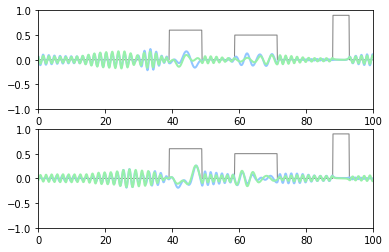

In [7]:
test_file = "../datasets/test/full_test_E0_0.0to9.0_BH_0.0to14.0/triple.txt"
pot_scalar = 10.0
# ckpt = "../models/full-gru/ckpts/final_step"
ckpt = "../models/demo-gru/ckpts/final_step"
config = Config(input_channels=3, hidden_size=69)
# config = Config(input_channels=2, hidden_size=46)
model = RNNModel(config)

data = retrieve_data(test_file, pot_scalar)
model.load_weights(ckpt)
result = get_result(model, config, data)
anim = build_anime(config, data, result)
HTML(anim.to_html5_video())

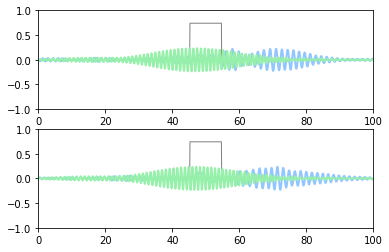

In [4]:
test_file = "../datasets/test/full_test_E0_0.0to9.0_BH_0.0to14.0/X0_15.1_S0_1.7_E0_6.4_BH_7.4_BW_9.4.txt"
pot_scalar = 10.0
ckpt = "../models/demo-lin/ckpts/final_step"
config = Config()
model = LinearModel(config)

data = retrieve_data(test_file, pot_scalar)
model.load_weights(ckpt)
result = get_result(model, config, data)
anim = build_anime(config, data, result, pot_scalar)
HTML(anim.to_html5_video())

In [1]:
result

NameError: name 'result' is not defined

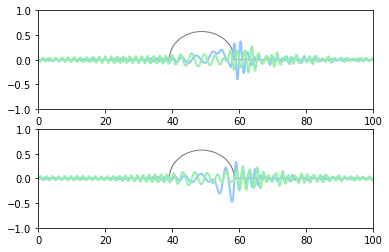

In [11]:
test_file = "../datasets/test/full_test_E0_0.0to9.0_BH_0.0to14.0/half-circle.txt"
pot_scalar = 10.0
# ckpt = "../models/full-gru/ckpts/final_step"
ckpt = "../models/demo-gru/ckpts/final_step"
config = Config(input_channels=3, hidden_size=69)
# config = Config(input_channels=2, hidden_size=46)
model = RNNModel(config)

data = retrieve_data(test_file, pot_scalar)
model.load_weights(ckpt)
result = get_result(model, config, data)
anim = build_anime(config, data, result)
HTML(anim.to_html5_video())

Text(0.5, 1.0, 'Difference')

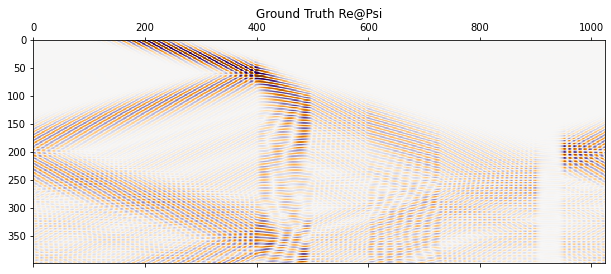

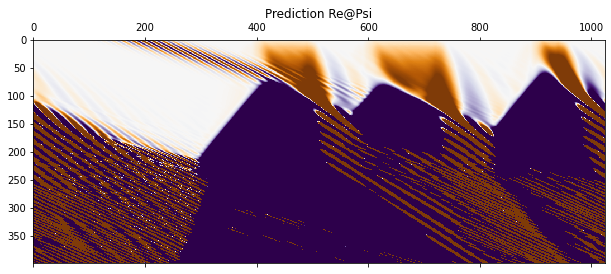

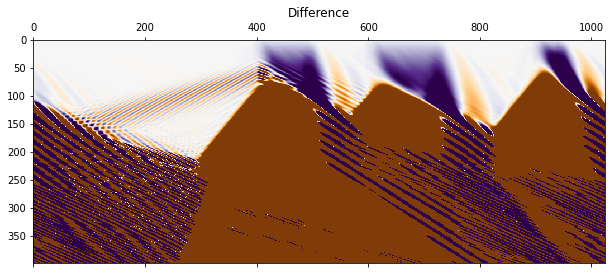

In [16]:
frames = result.shape[0]
plt.matshow(data["psi_re"][config.input_frames:config.input_frames+frames], vmax=0.4, vmin=-0.4, cmap="PuOr")
plt.title("Ground Truth Re@Psi")
plt.matshow(result[:, :, 0], vmax=0.4, vmin=-0.4, cmap="PuOr")
plt.title("Prediction Re@Psi")
plt.matshow(data["psi_re"][config.input_frames:config.input_frames+frames]-result[:, :, 0], vmax=0.4, vmin=-0.4, cmap="PuOr")
plt.title("Difference")

## Section 8: Hyperparameters Tuning


In [ ]:
plt.rc('xtick', labelsize='xx-large')
plt.rc('ytick', labelsize='xx-large')
fig, axs = plt.subplots(1, 2, figsize=(10, 3.5))
npzfile = np.load("frame.npz")
x = np.arange(4)
width = 0.3

all_loss = npzfile["all_loss"]
mae = np.mean(all_loss, axis = (1, 2))
best_mae = [np.min(mae[x::4]) for x in range(4)]
mean_mae = [np.mean(mae[x::4]) for x in range(4)]
metric_name = 'mean_absolute_error'

axs[0].bar(x - 0.17, mean_mae, width, label='Mean')
axs[0].bar(x + 0.17, best_mae, width, label='Best')
axs[0].set_xticks(x)
axs[0].set_xticklabels(["1", "2", "4", "8"], fontsize=16)
axs[0].set_xlabel("Input Time Steps", fontsize=16)
axs[0].set_ylabel('Mean Absolute Error', fontsize=16)


all_loss = npzfile["all_corr"]
mae = np.mean(all_loss, axis = (1, 2))
best_mae = [np.max(mae[x::4]) for x in range(4)]
mean_mae = [np.mean(mae[x::4]) for x in range(4)]
metric_name = 'mean_absolute_error'

axs[1].bar(x - 0.17, mean_mae, width, label='Mean')
axs[1].bar(x + 0.17, best_mae, width, label='Best')
axs[1].set_xticks(x)
axs[1].set_xticklabels(["1", "2", "4", "8"], fontsize=16)
axs[1].set_xlabel("Input Time Steps", fontsize=16)
axs[1].set_ylabel('Normalized Correlation', fontsize=16)
axs[1].set_ylim((0.98, 1.0))
axs[0].set_ylim((0., 0.008))

# plt.yscale('log')
axs[0].grid(axis='y')
axs[0].legend(fontsize=13)
axs[1].legend(fontsize=13)
axs[1].grid(axis='y')

fig.tight_layout()


In [ ]:
plt.rc('xtick', labelsize='xx-large')
plt.rc('ytick', labelsize='xx-large')
npzfile = np.load("window.npz")
fig, axs = plt.subplots(1, 2, figsize=(10, 3.5))
x = np.arange(3)
width = 0.3

all_loss = npzfile["all_loss"]
mae = np.mean(all_loss, axis = (1, 2))
best_mae = [np.min(mae[x::3]) for x in range(3)]
mean_mae = [np.mean(mae[x::3]) for x in range(3)]
metric_name = 'mean_absolute_error'

axs[0].bar(x - 0.17, mean_mae, width, label='Mean')
axs[0].bar(x + 0.17, best_mae, width, label='Best')
axs[0].set_xticks(x)
axs[0].set_xticklabels(["15", "23", "31",], fontsize=16)
axs[0].set_xlabel("Window Size (# of grid points)", fontsize=16)
axs[0].set_ylabel('Mean Absolute Error', fontsize=16)


all_loss = npzfile["all_corr"]
mae = np.mean(all_loss, axis = (1, 2))
best_mae = [np.max(mae[x::3]) for x in range(3)]
mean_mae = [np.mean(mae[x::3]) for x in range(3)]
metric_name = 'mean_absolute_error'

axs[1].bar(x - 0.17, mean_mae, width, label='Mean')
axs[1].bar(x + 0.17, best_mae, width, label='Best')
axs[1].set_xticks(x)
axs[1].set_xticklabels(["15", "23", "31",], fontsize=16)
axs[1].set_xlabel("Window Size (# of grid points)", fontsize=16)
axs[1].set_ylabel('Normalized Correlation', fontsize=16)
axs[1].set_ylim((0.97, 1.0))

# plt.yscale('log')
axs[0].grid(axis='y')
axs[0].legend(fontsize=13)
axs[1].legend(fontsize=13)
axs[1].grid(axis='y')

fig.tight_layout()
# plt.savefig('pt-window.pdf')


In [ ]:
plt.rc('xtick', labelsize='xx-large')
plt.rc('ytick', labelsize='xx-large')
npzfile = np.load("hidden.npz")
fig, axs = plt.subplots(1, 2, figsize=(10, 3.5))
x = np.arange(5)
x1 = [3, 5, 6, 7, 8]
width = 0.3

all_loss = npzfile["all_loss"]
mae = np.mean(all_loss, axis = (1, 2))
best_mae = [np.min(mae[x::9]) for x in x1]
mean_mae = [np.mean(mae[x::9]) for x in x1]
metric_name = 'mean_absolute_error'

# print(x)

axs[0].bar(x - 0.17, mean_mae, width, label='Mean')
axs[0].bar(x + 0.17, best_mae, width, label='Best')
axs[0].set_xticks(x)
axs[0].set_xticklabels(["46", "69", "92", "115", "138"], fontsize=16)
axs[0].set_xlabel("Hidden States Size", fontsize=16)
axs[0].set_ylabel('Mean Absolute Error', fontsize=16)


all_loss = npzfile["all_corr"]
mae = np.mean(all_loss, axis = (1, 2))
best_mae = [np.max(mae[x::9]) for x in x1]
mean_mae = [np.mean(mae[x::9]) for x in x1]
metric_name = 'mean_absolute_error'

axs[1].bar(x - 0.17, mean_mae, width, label='Mean')
axs[1].bar(x + 0.17, best_mae, width, label='Best')
axs[1].set_xticks(x)
axs[1].set_xticklabels(["46", "69", "92", "115", "138"], fontsize=16)
axs[1].set_xlabel("Hidden States Size", fontsize=16)
axs[1].set_ylabel('Normalized Correlation', fontsize=16)

axs[1].set_ylim((0.98, 1.0))

# plt.yscale('log')
axs[0].grid(axis='y')
axs[0].legend(fontsize=13)
axs[1].legend(fontsize=13)
axs[1].grid(axis='y')

fig.tight_layout()


## Section 9: Input-feature Importance


In [ ]:
def compute_gradients(model, inputs, target):
    with tf.GradientTape() as tape:
        tape.watch(inputs)
        pred = model(inputs)
        pred = pred[0, target[0], target[1]]
    return tape.gradient(pred, inputs)


def plot_ig(model, config, data, frame_num=0, window_num=500, target=(11, 0), bp=True):
    def build_plot(config, feature, resp, window_num):
        ylabel = ["$Re(\psi)$", "$Im(\psi)$", "Potential"]
        fig, axs = plt.subplots(3, 4, sharex=True, sharey='row', figsize=(15,3.5), )
        resp = resp.reshape(feature.shape)
        for i in range(4):
            for j in range(config.input_channels):
                x = np.arange(feature.shape[1])
                y = feature[i, :, j]
                s = resp[i, :, j]
                axs[j, i].plot(y, c="gray")
                spos = np.maximum(s, 0)
                sneg = np.minimum(s, 0)
                axs[j, i].scatter(x, y, c="red", s=1e3*np.abs(spos), alpha=0.4,)
                axs[j, i].scatter(x, y, c="blue", s=1e3*np.abs(sneg), alpha=0.4,)
                
                if j == 0:
                    axs[j, i].set_title(f"Input Time Step {i+176}", fontsize=18)
                if i == 0:
                    axs[j, i].set_ylabel(ylabel[j], fontsize=16)
                    axs[j, i].yaxis.set_label_coords(-0.2, 0.5)
                    
        plt.subplots_adjust(wspace=0.1, hspace=0.2)


    features = tf.stack((tf.constant(data["psi_re"], dtype=tf.float32), 
                         tf.constant(data["psi_im"], dtype=tf.float32), 
                         tf.constant(data["pot"], dtype=tf.float32)), axis=-1)
    feature = features[frame_num:frame_num+config.input_frames, window_num:window_num+config.window_size, :config.input_channels].numpy()
    
    g = compute_gradients(model, tf.constant([feature]), target=target)
    if bp:
        build_plot(config, feature, g.numpy(), window_num)
    return g.numpy()


test_file = "../datasets/test/full_test_E0_0.0to9.0_BH_0.0to14.0/steps.txt"

pot_scalar = 14.
ckpt = "../models/full-gru/ckpts/final_step"
config = Config()
model = RNNModel(config)
data = retrieve_data(test_file, pot_scalar)
model.load_weights(ckpt)
g = plot_ig(model, config, data, 176, 660, (11, 0))

# plt.savefig('response.pdf', bbox_inches = 'tight', pad_inches = 0)


In [ ]:
g = plot_ig(model, config, data, 176, 662, (11, 0))
g = plot_ig(model, config, data, 176, 664, (11, 0))
g = plot_ig(model, config, data, 176, 66, (11, 0))